# Query from Foursquare

In [92]:
import os
import json
import base64
import numpy as np
import geopandas as gpd
from typing import Optional
from pyiceberg.expressions import And, GreaterThanOrEqual, LessThanOrEqual
from pyiceberg.catalog import load_catalog


def read_token(token_path: str) -> str:
    """
    Read and return the Foursquare API token from a local JSON file.

    The function supports two valid JSON formats:
    1) An object with a "token" key: {"token": "xxxxx"}
    2) A plain string containing the token: "xxxxx"

    Parameters
    ----------
    token_path : str
        Local file path to the JSON file containing the token.

    Returns
    -------
    str
        The token string extracted from the file.

    Raises
    ------
    ValueError
        If the JSON file format is invalid or does not contain a valid token.
    """
    with open(token_path, "r") as f:
        data = json.load(f)
    if isinstance(data, dict) and "token" in data:
        return data["token"]
    if isinstance(data, str):
        return data
    raise ValueError("Token JSON must be either a string or an object with a key 'token'.")


def json_str_tr(x):
    """
    Convert non-JSON-serializable Python objects (e.g., lists, dicts, arrays)
    into string representations that can be safely exported or visualized.

    Parameters
    ----------
    x : Any
        The input value to be converted.

    Returns
    -------
    str or None
        The JSON-compatible string representation of the input value.
    """
    if x is None:
        return None
    elif isinstance(x, (str, int, float, bool)):
        return str(x)
    elif isinstance(x, (list, tuple, set, np.ndarray)):
        return str(list(x))
    elif isinstance(x, dict):
        return str({k: json_str_tr(v) for k, v in x.items()})
    elif isinstance(x, (bytes, bytearray)):
        return base64.b64encode(x).decode("ascii")
    else:
        return str(x)


def query_foursquare(
    token_path: str,
    minLon: float,
    maxLon: float,
    minLat: float,
    maxLat: float,
    limit_size: Optional[int] = None,
    table_name: str = "datasets.places_os",
    uri: str = "https://catalog.h3-hub.foursquare.com/iceberg",
    warehouse: str = "places",
):
    """
    Query Points of Interest (POIs) from the Foursquare Iceberg Catalog
    within a given geographic bounding box and return results as a GeoDataFrame.

    This function connects to the Foursquare H3-Hub Iceberg dataset, applies a spatial filter
    (latitude/longitude bounds), retrieves the data as a Pandas DataFrame, converts it into
    a GeoDataFrame (EPSG:4326), and ensures all complex fields are JSON-serializable.

    Parameters
    ----------
    token_path : str
        Path to the local JSON file containing the Foursquare API token.
        The file should follow one of these formats:
        - {"token": "xxxxx"}
        - "xxxxx"
    minLon, maxLon, minLat, maxLat : float
        Geographic bounding box coordinates (in WGS84) for the query.
    limit_size : int, optional
        Maximum number of rows to return. If None (default), returns all available rows.
    table_name : str, default "datasets.places_os"
        Name of the Iceberg table to query.
    uri : str, default "https://catalog.h3-hub.foursquare.com/iceberg"
        Base URI of the Foursquare Iceberg REST catalog.
    warehouse : str, default "places"
        Name of the warehouse used by the Iceberg catalog.

    Returns
    -------
    geopandas.GeoDataFrame
        A GeoDataFrame containing POI records with WGS84 geometry.

    Examples
    --------
    Limit to 5000 rows:
    >>> gdf = query_foursquare(
    ...     token_path="~/foursquare_token.json",
    ...     minLon=-119.8694, maxLon=-119.85346,
    ...     minLat=34.40887, maxLat=34.41727,
    ...     limit_size=5000
    ... )

    Retrieve all available records (no limit):
    >>> gdf = query_foursquare(
    ...     token_path="~/foursquare_token.json",
    ...     minLon=-119.8694, maxLon=-119.85346,
    ...     minLat=34.40887, maxLat=34.41727
    ... )
    """
    # --- Load token ---
    token = read_token(os.path.expanduser(token_path))

    # --- Connect to the Iceberg catalog ---
    catalog = load_catalog(
        "default",
        **{
            "warehouse": warehouse,
            "uri": uri,
            "token": token,
            "header.content-type": "application/vnd.api+json",
            "rest-metrics-reporting-enabled": "false",
        },
    )

    # --- Load target table ---
    table = catalog.load_table(table_name)

    # --- Define spatial filter ---
    expr = And(
        And(GreaterThanOrEqual("longitude", minLon), LessThanOrEqual("longitude", maxLon)),
        And(GreaterThanOrEqual("latitude", minLat), LessThanOrEqual("latitude", maxLat)),
    )

    # --- Run query ---
    df = table.scan(row_filter=expr, limit=limit_size).to_pandas()

    # --- Convert to GeoDataFrame ---
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
        crs="EPSG:4326",
    )

    # --- Clean up non-serializable columns ---
    for col in gdf.columns:
        if col != "geometry":
            if gdf[col].apply(lambda x: isinstance(x, (list, dict, np.ndarray, bytes, bytearray))).any():
                gdf[col] = gdf[col].apply(json_str_tr)

    return gdf


In [ ]:
foursquare_places = query_foursquare(token_path="/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/foursquare_token.json",
                       minLon=-119.8694, maxLon=-119.85346,
                       minLat=34.40887, maxLat=34.41727)


In [ ]:
foursquare_places

,fsq_place_id,name,latitude,longitude,address,locality,region,postcode,admin_region,post_town,...,facebook_id,instagram,twitter,fsq_category_ids,fsq_category_labels,placemaker_url,unresolved_flags,geom,bbox,geometry
0,4e2b3a82b61cd0108372ed61,6670 Trigo,34.409345,-119.858588,None,None,None,None,None,None,...,NaN,None,None,['4bf58dd8d48988d1a3941735'],['Community and Government > Education > Colle...,https://foursquare.com/placemakers/review-plac...,None,AAAAAAHAXfbzHPEmT0BBNGVsqtOT,"{'xmin': '-119.85858844327707', 'ymin': '34.40...",POINT (-119.85859 34.40935)
1,53c336aa498eb2376a9d91e5,The Sea Kastle,34.409517,-119.858524,None,Isla Vista,CA,None,None,None,...,NaN,None,None,['50aaa49e4b90af0d42d5de11'],['Landmarks and Outdoors > Castle'],https://foursquare.com/placemakers/review-plac...,None,AAAAAAHAXfbyDTy1U0BBNGsJb3/T,"{'xmin': '-119.85852366379304', 'ymin': '34.40...",POINT (-119.85852 34.40952)
2,4eacda6eb63433968784ddfe,Kappa $enior,34.409517,-119.858524,None,Goleta,CA,None,None,None,...,NaN,None,None,['4bf58dd8d48988d141941735'],['Community and Government > Education > Colle...,https://foursquare.com/placemakers/review-plac...,None,AAAAAAHAXfbyDTy1U0BBNGsJb3/T,"{'xmin': '-119.85852366379304', 'ymin': '34.40...",POINT (-119.85852 34.40952)
3,4d7a85248e775941ea29453a,Danger Cliff,34.409422,-119.859084,6607 Del Playa Dr,Goleta,CA,93117,None,None,...,NaN,None,None,['4bf58dd8d48988d162941735'],['Landmarks and Outdoors > Other Great Outdoors'],https://foursquare.com/placemakers/review-plac...,None,AAAAAAHAXfb7O3a2LUBBNGfz0AzB,"{'xmin': '-119.85908400147373', 'ymin': '34.40...",POINT (-119.85908 34.40942)
4,4bb06e67f964a5204f453ce3,Dp Madness,34.409432,-119.859577,6619 Del Playa Dr,Goleta,CA,93117,None,None,...,NaN,None,None,None,None,https://foursquare.com/placemakers/review-plac...,None,AAAAAAHAXfcDUK+XvUBBNGhHi3EV,"{'xmin': '-119.85957734248855', 'ymin': '34.40...",POINT (-119.85958 34.40943)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,52560d47498e898705e5e861,Casa de Brooke,34.408923,-119.854771,6521 Del Playa Dr,Isla Vista,CA,93117,None,None,...,NaN,None,None,['4d954b06a243a5684965b473'],['Community and Government > Residential Build...,https://foursquare.com/placemakers/review-plac...,None,AAAAAAHAXfa0kmpYP0BBNFeUhqiE,"{'xmin': '-119.85477123627878', 'ymin': '34.40...",POINT (-119.85477 34.40892)
626,515f15c6e4b0e95e9b15d533,El Nido Palace,34.409729,-119.854431,None,Isla Vista,CA,None,None,None,...,NaN,None,None,['4d954b06a243a5684965b473'],['Community and Government > Residential Build...,https://foursquare.com/placemakers/review-plac...,None,AAAAAAHAXfavAVcJ4EBBNHIC9DX+,"{'xmin': '-119.85443147182332', 'ymin': '34.40...",POINT (-119.85443 34.40973)
627,4da14851b3e7236ae02a0779,D.P.,34.409437,-119.854577,None,None,None,93117,None,None,...,NaN,None,None,['4bf58dd8d48988d116941735'],['Dining and Drinking > Bar'],https://foursquare.com/placemakers/review-plac...,None,AAAAAAHAXfaxYzW2N0BBNGhq1H55,"{'xmin': '-119.85457687611857', 'ymin': '34.40...",POINT (-119.85458 34.40944)
628,5258dd25498e437e264bcd46,Chillapalooza,34.409285,-119.854220,None,Isla Vista,CA,None,None,None,...,NaN,None,None,['4bf58dd8d48988d116941735'],['Dining and Drinking > Bar'],https://foursquare.com/placemakers/review-plac...,None,AAAAAAHAXfariUMud0BBNGN3m5zS,"{'xmin': '-119.85421973763174', 'ymin': '34.40...",POINT (-119.85422 34.40929)


# Query from Google Place API

In [6]:
import math
import time
import json
import warnings
from typing import Optional, Iterable, List, Dict, Any, Tuple

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box, Point
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# contextily is only needed for the web basemap
try:
    import contextily as ctx
    _HAS_CTX = True
except Exception:
    _HAS_CTX = False
    warnings.warn("⚠️ contextily not found, basemap will be skipped.")

import requests


def read_token(token_path: str) -> str:
    """
    Read and return the token from a local JSON file.

    The function supports two valid JSON formats:
    1) An object with a "token" key: {"token": "xxxxx"}
    2) A plain string containing the token: "xxxxx"

    Parameters
    ----------
    token_path : str
        Local file path to the JSON file containing the token.

    Returns
    -------
    str
        The token string extracted from the file.

    Raises
    ------
    ValueError
        If the JSON file format is invalid or does not contain a valid token.
    """
    with open(token_path, "r") as f:
        data = json.load(f)
    if isinstance(data, dict) and "token" in data:
        return data["token"]
    if isinstance(data, str):
        return data
    raise ValueError("Token JSON must be either a string or an object with a key 'token'.")


def circle_center(
    min_lon: float,
    max_lon: float,
    min_lat: float,
    max_lat: float,
    R: float,
) -> gpd.GeoDataFrame:
    """
    Generate a grid of circle polygons inside a geographic bounding box and (optionally) plot them
    over a web basemap. Returns the circle polygons in EPSG:4326 (lon/lat).

    Parameters
    ----------
    min_lon : float
        Minimum longitude (degrees, EPSG:4326).
    max_lon : float
        Maximum longitude (degrees, EPSG:4326). Must be > min_lon.
    min_lat : float
        Minimum latitude (degrees, EPSG:4326).
    max_lat : float
        Maximum latitude (degrees, EPSG:4326). Must be > min_lat.
    R : float
        Grid half-spacing **in meters** (in Web Mercator, EPSG:3857). The grid centers are spaced
        every `2*R` meters in both X and Y. Each circle will have radius `R * sqrt(2)` meters
        (this matches the behavior in your snippet).

    Returns
    -------
    gdf_circles_4326 : geopandas.GeoDataFrame
        Circle polygons in EPSG:4326 (lon/lat). Each row is one circle geometry.

    Notes
    -----
    - Workflow:
        1) Build the bbox polygon in EPSG:4326.
        2) Reproject to EPSG:3857 to work in meters.
        3) Create a regular grid of centers at spacing 2*R meters, inset by R from the bbox edges.
        4) Buffer each center by `R*sqrt(2)` to form a circle polygon (resolution=64 for smoothness).
        5) Plot (optional) in 3857 so web tiles align correctly.
        6) Reproject circle polygons back to EPSG:4326 and return them.
    
    How to run:
    -----
    min_lon, max_lon = -119.8694, -119.85346
    min_lat, max_lat = 34.40887, 34.41727
    R = 100
    circles = circle_center(
        min_lon=min_lon,
        max_lon=max_lon,
        min_lat=min_lat,
        max_lat=max_lat,
        R=R
    )
    """
    # -----------------------------
    # 0) Basic input validation
    # -----------------------------
    if not (isinstance(min_lon, (int, float)) and isinstance(max_lon, (int, float))
            and isinstance(min_lat, (int, float)) and isinstance(max_lat, (int, float))):
        raise TypeError("min_lon, max_lon, min_lat, max_lat must be numeric (float or int).")
    if not (max_lon > min_lon and max_lat > min_lat):
        raise ValueError("max_lon must be > min_lon and max_lat must be > min_lat.")
    if not (isinstance(R, (int, float)) and R > 0):
        raise ValueError("R must be a positive number (meters).")

    # -----------------------------
    # 1) Build bbox in EPSG:4326
    # -----------------------------
    poly_4326 = box(min_lon, min_lat, max_lon, max_lat)
    gdf_bbox_4326 = gpd.GeoDataFrame({"name": ["bbox_4326"]}, geometry=[poly_4326], crs="EPSG:4326")

    # -----------------------------
    # 2) Reproject bbox to EPSG:3857 (meters)
    # -----------------------------
    gdf_bbox_3857 = gdf_bbox_4326.to_crs(epsg=3857)
    minx, miny, maxx, maxy = gdf_bbox_3857.total_bounds

    # -----------------------------
    # 3) Grid centers inside bbox
    #    Spacing = 2R; inset by R from each side
    # -----------------------------
    xs = np.arange(minx + R, maxx + 1e-9, 2 * R)
    ys = np.arange(miny + R, maxy + 1e-9, 2 * R)
    if xs.size == 0 or ys.size == 0:
        warnings.warn("⚠️ No grid centers generated — check if R is too large or bbox too small.")
        centers_xy = np.empty((0, 2))
    else:
        xx, yy = np.meshgrid(xs, ys)
        centers_xy = np.column_stack([xx.ravel(), yy.ravel()])

    # -----------------------------
    # 4) Build circles in 3857
    #    Circle radius = R * sqrt(2)
    # -----------------------------
    radius_m = R * math.sqrt(2.0)
    circles_3857 = [Point(cx, cy).buffer(radius_m, resolution=64) for (cx, cy) in centers_xy]
    gdf_circles_3857 = gpd.GeoDataFrame(geometry=circles_3857, crs="EPSG:3857")
    gdf_circles_4326 = gdf_circles_3857.to_crs(epsg=4326)

    return gdf_circles_4326


def places_nearby_grid(
    circles_4326: gpd.GeoDataFrame,
    token: str,
    *,
    radius_m: float,
    max_result_count: int = 20,         # per page, Google allows up to 20 for v1 nearby
    max_pages_per_center: int = 3,      # safety cap for pagination
    page_sleep_sec: float = 1.5,        # small wait between pages; Google may need a short delay
    included_primary_types: Optional[List[str]] = None,
    excluded_primary_types: Optional[List[str]] = None,
    extra_fieldmask: Optional[Iterable[str]] = None,
) -> gpd.GeoDataFrame:
    """
    Query Google Places API v1 `places:searchNearby` for each circle center (centroid) and
    concatenate all results into one pandas DataFrame. Handles pagination automatically.

    Parameters
    ----------
    circles : GeoDataFrame
        A GeoDataFrame of circle polygons in EPSG:4326. The centroid of each polygon will be used
        as the query center (lat/lon) for the Places request.
    token : str
        Google Maps Platform API key (Places API enabled).
    radius_m : float
        Search radius in meters, applied to every query (per circle) = R.np.squart(2.0).
    max_result_count : int, default 20
        Number of results per page. Google Nearby v1 typically returns up to 20 per page.
    max_pages_per_center : int, default 3
        Maximum number of pages to fetch for each centroid to avoid unbounded loops.
    page_sleep_sec : float, default 1.5
        Sleep time between page fetches. Some nextPageTokens require a brief delay to become valid.
    included_primary_types : list[str] or None
        If provided, send as `includedPrimaryTypes` in request JSON.
    excluded_primary_types : list[str] or None
        If provided, send as `excludedPrimaryTypes` in request JSON.
    extra_fieldmask : Iterable[str] or None
        Extra fields to request. Base fields are included; you can append more here.

    Returns
    -------
    geopandas.GeoDataFrame
        A GeoDataFrame of all places found across all circle centers with columns:
        ['id','name','address','category','lat','lon','geometry'].
        Duplicates are dropped by `id` (keep='first').
        
    How to run:
    -------
    excluded = [
        "apartment_building",
        "apartment_complex",
        "condominium_complex",
        "housing_complex",
    ]

    gdf_places = places_nearby_grid(
        circles=circles,
        token=token,
        radius_m=R * math.sqrt(2.0),     # Use your R value, or the radius of each circle
        max_result_count=20,           # Up to 20 per page
        max_pages_per_center=3,        # Up to 3 pages per center (for safety)
        page_sleep_sec=0.1,            # Wait 2 seconds before next page
        included_primary_types=None,   # e.g., ["restaurant"]
        excluded_primary_types=excluded,
        extra_fieldmask=None           # If you want more fields, pass a list here
    )
        
    """

    url = "https://places.googleapis.com/v1/places:searchNearby"
    base_fields = [
        "places.id",
        "places.displayName",
        "places.formattedAddress",
        "places.location",
        "places.primaryType",
    ]
    if extra_fieldmask:
        base_fields.extend(list(extra_fieldmask))

    headers = {
        "Content-Type": "application/json",
        "X-Goog-Api-Key": token,
        "X-Goog-FieldMask": ",".join(base_fields),
    }

    # -----------------------------
    # 0) Get centroids for query points（calculating by crs 3857 and then transfer to 4326）
    # -----------------------------
    circles_m = circles_4326.to_crs(epsg=3857)
    centroids_m = circles_m.geometry.centroid
    centroids = gpd.GeoSeries(centroids_m, crs="EPSG:3857").to_crs(epsg=4326)
    centers = list(zip(centroids.y, centroids.x))  # (lat, lon)


    # -----------------------------
    # 1) Collect included & excluded POI type
    # -----------------------------
    included_primary_types = list(included_primary_types or [])
    excluded_primary_types = list(excluded_primary_types or [])


    # -----------------------------
    # 2) Interatively query from google places
    # -----------------------------
    rows: List[Dict[str, Any]] = []
    with requests.Session() as sess:
        for idx, (lat, lon) in enumerate(centers):
            payload_base = {
                "locationRestriction": {
                    "circle": {
                        "center": {"latitude": float(lat), "longitude": float(lon)},
                        "radius": float(radius_m),
                    }
                },
                "maxResultCount": int(max_result_count),
            }
            if included_primary_types:
                payload_base["includedPrimaryTypes"] = included_primary_types
            if excluded_primary_types:
                payload_base["excludedPrimaryTypes"] = excluded_primary_types

            next_page_token = None
            page_count = 0

            while True:
                page_count += 1
                payload = dict(payload_base)
                if next_page_token:
                    payload["pageToken"] = next_page_token

                r = sess.post(url, headers=headers, json=payload, timeout=30)
                if r.status_code != 200:
                    print(f"❌ HTTP {r.status_code} at center {idx} ({lat:.6f},{lon:.6f}): {r.text}")
                    break

                data = r.json() or {}
                places = data.get("places", [])
                for p in places:
                    rows.append(
                        {
                            "id": p.get("id"),
                            "name": (p.get("displayName") or {}).get("text"),
                            "address": p.get("formattedAddress"),
                            "category": p.get("primaryType"),
                            "lat": (p.get("location") or {}).get("latitude"),
                            "lon": (p.get("location") or {}).get("longitude"),
                        }
                    )

                next_page_token = data.get("nextPageToken") or data.get("next_page_token")
                if not next_page_token or page_count >= max_pages_per_center:
                    break
                time.sleep(page_sleep_sec)

    df = pd.DataFrame(rows)
    if df.empty:
        return gpd.GeoDataFrame(df, geometry=[], crs="EPSG:4326")

    # -----------------------------
    # 3) Delete duplicate POI points and transfer dataframe into geodataframe
    # -----------------------------
    df = df.drop_duplicates(subset=["id"], keep="first").reset_index(drop=True)
    df["lat"] = pd.to_numeric(df["lat"], errors="coerce")
    df["lon"] = pd.to_numeric(df["lon"], errors="coerce")
    df = df.dropna(subset=["lat", "lon"])

    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["lon"], df["lat"]), crs="EPSG:4326")
    return gdf


def google_places_grid_search(
    min_lon: float,
    max_lon: float,
    min_lat: float,
    max_lat: float,
    R: float,
    token: str,
    show_plot: bool = False,
    basemap_zoom: int = 17,
    basemap_provider: Optional[object] = None,
    max_result_count: int = 20,
    max_pages_per_center: int = 3,
    page_sleep_sec: float = 1.5,
    included_primary_types: Optional[List[str]] = None,
    excluded_primary_types: Optional[List[str]] = None,
    extra_fieldmask: Optional[Iterable[str]] = None,
) -> Tuple[gpd.GeoDataFrame, gpd.GeoDataFrame]:
    """
    Unified entry function: Generate circle grid → Query Google Places v1:searchNearby → Visualize results.

    Parameters
    ----
    - min_lon, max_lon, min_lat, max_lat: Bounding box in EPSG:4326 coordinates (longitude/latitude).
    - R: Half grid spacing in meters (grid step = 2R, each circle radius = R * sqrt(2)).
    - token: Google Maps Platform API key (Places API must be enabled).
    - show_plot: Whether to visualize the result (red = bounding box, light blue = circles, red = POIs).
    - basemap_zoom, basemap_provider: Basemap settings (require contextily to display).
    - max_result_count, max_pages_per_center, page_sleep_sec: Pagination and throttling settings for Places API requests.
    - included_primary_types, excluded_primary_types, extra_fieldmask: Category filters and additional fields to request.

    How to run:
    ----
    # === Define Input parameter ===
    min_lon, max_lon = -119.8694, -119.85346
    min_lat, max_lat = 34.40887, 34.41727
    R = 100  #  m
    token = read_token("/path/googleplace_token.json")

    excluded = [
        "apartment_building",
        "apartment_complex",
        "condominium_complex",
        "housing_complex",
    ]

    gdf_places = google_places_grid_search(
        min_lon=min_lon,
        max_lon=max_lon,
        min_lat=min_lat,
        max_lat=max_lat,
        R=R,
        token=token,
        show_plot=True,
        basemap_zoom=17,
        basemap_provider=None,         # default Esri.WorldImagery
        max_result_count=20,
        max_pages_per_center=3,
        page_sleep_sec=1.5,
        included_primary_types=None,   # ex ["restaurant"]
        excluded_primary_types=excluded,
        extra_fieldmask=None           # can add more field
    )

    Returns
    ----
      - gdf_places_4326: GeoDataFrame of POI points in EPSG:4326 (longitude/latitude).
      - plot figure(option)
    """
    # -----------------------------
    # 1) Generate circle grid
    # -----------------------------
    gdf_circles = circle_center(
        min_lon=min_lon,
        max_lon=max_lon,
        min_lat=min_lat,
        max_lat=max_lat,
        R=R
    )

    # -----------------------------
    # 2) Query Google Places v1:searchNearby
    # -----------------------------
    radius_m = R * math.sqrt(2.0)
    gdf_places = places_nearby_grid(
        circles_4326=gdf_circles,
        token=token,
        radius_m=radius_m,
        max_result_count=max_result_count,
        max_pages_per_center=max_pages_per_center,
        page_sleep_sec=page_sleep_sec,
        included_primary_types=included_primary_types,
        excluded_primary_types=excluded_primary_types,
        extra_fieldmask=extra_fieldmask,
    )

    # -----------------------------
    # 3) Visualize results
    # -----------------------------
    if show_plot:
        bbox_4326 = gpd.GeoDataFrame(
            geometry=[box(min_lon, min_lat, max_lon, max_lat)],
            crs="EPSG:4326",
        )
        bbox_3857 = bbox_4326.to_crs(epsg=3857)
        circles_3857 = gdf_circles.to_crs(epsg=3857)
        places_3857 = gdf_places.to_crs(epsg=3857) if not gdf_places.empty else gpd.GeoDataFrame(geometry=[], crs="EPSG:3857")

        fig, ax = plt.subplots(figsize=(12, 12))
        bbox_3857.plot(ax=ax, edgecolor="red", facecolor="none", linewidth=2)
        circles_3857.plot(ax=ax, edgecolor="blue", facecolor="lightblue", alpha=0.35, linewidth=0.8)
        places_3857.plot(ax=ax, markersize=12, color="red", alpha=0.8)

        xmin, ymin, xmax, ymax = bbox_3857.total_bounds
        ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)

        if _HAS_CTX:
            provider = basemap_provider or ctx.providers.Esri.WorldImagery
            try:
                ctx.add_basemap(ax, source=provider, zoom=basemap_zoom)
            except Exception as e:
                warnings.warn(f"⚠️ Basemap failed to load: {e}")

        handles = [
            Patch(facecolor='none', edgecolor='red', linewidth=2, label='Bounding Box'),
            Patch(facecolor='lightblue', edgecolor='blue', alpha=0.5, label='Circles'),
        ]
        if not gdf_places.empty:
            poi_handle = plt.Line2D([0], [0], marker='o', linestyle='None', markersize=6, color='red', label='POIs')
            handles.append(poi_handle)

        ax.legend(handles=handles, loc='upper left')
        ax.set_axis_off()
        ax.set_title("BBox + Circle Grid + Google Places", fontsize=14)
        plt.tight_layout()
        plt.show()

    return gdf_places

In [1]:
# # === Define Input parameter ===
# min_lon, max_lon = -119.8694, -119.85346
# min_lat, max_lat = 34.40887, 34.41727
# R = 100  #  m
# token = read_token("/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/googleplace_token.json")

# excluded = [
#     "apartment_building",
#     "apartment_complex",
#     "condominium_complex",
#     "housing_complex",
# ]

# google_places_100 = google_places_grid_search(
#     min_lon=min_lon,
#     max_lon=max_lon,
#     min_lat=min_lat,
#     max_lat=max_lat,
#     R=R,
#     token=token,
#     show_plot=True,
#     basemap_zoom=17,
#     basemap_provider=None,         # default Esri.WorldImagery
#     max_result_count=20,
#     max_pages_per_center=3,
#     page_sleep_sec=1.5,
#     included_primary_types=None,   # ex ["restaurant"]
#     excluded_primary_types=excluded,
#     extra_fieldmask=None           # can add more field
# )

In [2]:
# # === Define Input parameter ===
# min_lon, max_lon = -119.8694, -119.85346
# min_lat, max_lat = 34.40887, 34.41727
# R = 100  #  m
# token = read_token("/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/googleplace_token.json")

# excluded = [
#     "apartment_building",
#     "apartment_complex",
#     "condominium_complex",
#     "housing_complex",
# ]

# include = [
#     "car_dealer",
#     "car_rental",
#     "car_repair",
#     "car_wash",
#     "electric_vehicle_charging_station",
#     "gas_station",
#     "parking",
#     "rest_stop",
# ]

# google_automotive_100 = google_places_grid_search(
#     min_lon=min_lon,
#     max_lon=max_lon,
#     min_lat=min_lat,
#     max_lat=max_lat,
#     R=R,
#     token=token,
#     show_plot=True,
#     basemap_zoom=17,
#     basemap_provider=None,         # default Esri.WorldImagery
#     max_result_count=20,
#     max_pages_per_center=3,
#     page_sleep_sec=1.5,
#     included_primary_types=include,   # ex ["restaurant"]
#     excluded_primary_types=excluded,
#     extra_fieldmask=None           # can add more field
# )


In [3]:
# # === Define Input parameter ===
# min_lon, max_lon = -119.8694, -119.85346
# min_lat, max_lat = 34.40887, 34.41727
# R = 100  #  m
# token = read_token("/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/googleplace_token.json")

# excluded = [
#     "apartment_building",
#     "apartment_complex",
#     "condominium_complex",
#     "housing_complex",
# ]

# include = [
#     "corporate_office",
#     "farm",
#     "ranch",
# ]

# google_business_100 = google_places_grid_search(
#     min_lon=min_lon,
#     max_lon=max_lon,
#     min_lat=min_lat,
#     max_lat=max_lat,
#     R=R,
#     token=token,
#     show_plot=True,
#     basemap_zoom=17,
#     basemap_provider=None,         # default Esri.WorldImagery
#     max_result_count=20,
#     max_pages_per_center=3,
#     page_sleep_sec=1.5,
#     included_primary_types=include,   # ex ["restaurant"]
#     excluded_primary_types=excluded,
#     extra_fieldmask=None           # can add more field
# )


In [4]:
# # === Define Input parameter ===
# min_lon, max_lon = -119.8694, -119.85346
# min_lat, max_lat = 34.40887, 34.41727
# R = 100  #  m
# token = read_token("/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/googleplace_token.json")

# excluded = [
#     "apartment_building",
#     "apartment_complex",
#     "condominium_complex",
#     "housing_complex",
# ]

# include = [
#     "art_gallery",
#     "art_studio",
#     "auditorium",
#     "cultural_landmark",
#     "historical_place",
#     "monument",
#     "museum",
#     "performing_arts_theater",
#     "sculpture",
# ]

# google_culture_100 = google_places_grid_search(
#     min_lon=min_lon,
#     max_lon=max_lon,
#     min_lat=min_lat,
#     max_lat=max_lat,
#     R=R,
#     token=token,
#     show_plot=True,
#     basemap_zoom=17,
#     basemap_provider=None,         # default Esri.WorldImagery
#     max_result_count=20,
#     max_pages_per_center=3,
#     page_sleep_sec=1.5,
#     included_primary_types=include,   # ex ["restaurant"]
#     excluded_primary_types=excluded,
#     extra_fieldmask=None           # can add more field
# )


In [5]:
# # === Define Input parameter ===
# min_lon, max_lon = -119.8694, -119.85346
# min_lat, max_lat = 34.40887, 34.41727
# R = 100  #  m
# token = read_token("/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/googleplace_token.json")

# excluded = [
#     "apartment_building",
#     "apartment_complex",
#     "condominium_complex",
#     "housing_complex",
# ]

# include = [
#     "library",
#     "preschool",
#     "primary_school",
#     "school",
#     "secondary_school",
#     "university",
# ]

# google_education_100 = google_places_grid_search(
#     min_lon=min_lon,
#     max_lon=max_lon,
#     min_lat=min_lat,
#     max_lat=max_lat,
#     R=R,
#     token=token,
#     show_plot=True,
#     basemap_zoom=17,
#     basemap_provider=None,         # default Esri.WorldImagery
#     max_result_count=20,
#     max_pages_per_center=3,
#     page_sleep_sec=1.5,
#     included_primary_types=include,   # ex ["restaurant"]
#     excluded_primary_types=excluded,
#     extra_fieldmask=None           # can add more field
# )


In [6]:
# # === Define Input parameter ===
# min_lon, max_lon = -119.8694, -119.85346
# min_lat, max_lat = 34.40887, 34.41727
# R = 100  #  m
# token = read_token("/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/googleplace_token.json")

# excluded = [
#     "apartment_building",
#     "apartment_complex",
#     "condominium_complex",
#     "housing_complex",
# ]

# include = [
#     "adventure_sports_center",
#     "amphitheatre",
#     "amusement_center",
#     "amusement_park",
#     "aquarium",
#     "banquet_hall",
#     "barbecue_area",
#     "botanical_garden",
#     "bowling_alley",
#     "casino",
#     "childrens_camp",
#     "comedy_club",
#     "community_center",
#     "concert_hall",
#     "convention_center",
#     "cultural_center",
#     "cycling_park",
#     "dance_hall",
#     "dog_park",
#     "event_venue",
#     "ferris_wheel",
#     "garden",
#     "hiking_area",
#     "historical_landmark",
#     "internet_cafe",
#     "karaoke",
#     "marina",
#     "movie_rental",
#     "movie_theater",
#     "national_park",
#     "night_club",
#     "observation_deck",
#     "off_roading_area",
#     "opera_house",
#     "park",
#     "philharmonic_hall",
#     "picnic_ground",
#     "planetarium",
#     "plaza",
#     "roller_coaster",
#     "skateboard_park",
#     "state_park",
#     "tourist_attraction",
#     "video_arcade",
#     "visitor_center",
#     "water_park",
#     "wedding_venue",
#     "wildlife_park",
#     "wildlife_refuge",
#     "zoo",
# ]

# google_entertainment_100 = google_places_grid_search(
#     min_lon=min_lon,
#     max_lon=max_lon,
#     min_lat=min_lat,
#     max_lat=max_lat,
#     R=R,
#     token=token,
#     show_plot=True,
#     basemap_zoom=17,
#     basemap_provider=None,         # default Esri.WorldImagery
#     max_result_count=20,
#     max_pages_per_center=3,
#     page_sleep_sec=1.5,
#     included_primary_types=include,   # ex ["restaurant"]
#     excluded_primary_types=excluded,
#     extra_fieldmask=None           # can add more field
# )


In [7]:
# # === Define Input parameter ===
# min_lon, max_lon = -119.8694, -119.85346
# min_lat, max_lat = 34.40887, 34.41727
# R = 100  #  m
# token = read_token("/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/googleplace_token.json")

# excluded = [
#     "apartment_building",
#     "apartment_complex",
#     "condominium_complex",
#     "housing_complex",
# ]

# include = [
#     "public_bath",
#     "public_bathroom",
#     "stable",
# ]

# google_facilities_100 = google_places_grid_search(
#     min_lon=min_lon,
#     max_lon=max_lon,
#     min_lat=min_lat,
#     max_lat=max_lat,
#     R=R,
#     token=token,
#     show_plot=True,
#     basemap_zoom=17,
#     basemap_provider=None,         # default Esri.WorldImagery
#     max_result_count=20,
#     max_pages_per_center=3,
#     page_sleep_sec=1.5,
#     included_primary_types=include,   # ex ["restaurant"]
#     excluded_primary_types=excluded,
#     extra_fieldmask=None           # can add more field
# )


In [8]:
# # === Define Input parameter ===
# min_lon, max_lon = -119.8694, -119.85346
# min_lat, max_lat = 34.40887, 34.41727
# R = 100  #  m
# token = read_token("/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/googleplace_token.json")

# excluded = [
#     "apartment_building",
#     "apartment_complex",
#     "condominium_complex",
#     "housing_complex",
# ]

# include = [
#     "accounting",
#     "atm",
#     "bank",
# ]

# google_finance_100 = google_places_grid_search(
#     min_lon=min_lon,
#     max_lon=max_lon,
#     min_lat=min_lat,
#     max_lat=max_lat,
#     R=R,
#     token=token,
#     show_plot=True,
#     basemap_zoom=17,
#     basemap_provider=None,         # default Esri.WorldImagery
#     max_result_count=20,
#     max_pages_per_center=3,
#     page_sleep_sec=1.5,
#     included_primary_types=include,   # ex ["restaurant"]
#     excluded_primary_types=excluded,
#     extra_fieldmask=None           # can add more field
# )


In [9]:
# # === Define Input parameter ===
# min_lon, max_lon = -119.8694, -119.85346
# min_lat, max_lat = 34.40887, 34.41727
# R = 100  #  m
# token = read_token("/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/googleplace_token.json")

# excluded = [
#     "apartment_building",
#     "apartment_complex",
#     "condominium_complex",
#     "housing_complex",
# ]

# include = [
#     "acai_shop",
#     "afghani_restaurant",
#     "african_restaurant",
#     "american_restaurant",
#     "asian_restaurant",
#     "bagel_shop",
#     "bakery",
#     "bar",
#     "bar_and_grill",
#     "barbecue_restaurant",
#     "brazilian_restaurant",
#     "breakfast_restaurant",
#     "brunch_restaurant",
#     "buffet_restaurant",
#     "cafe",
#     "cafeteria",
#     "candy_store",
#     "cat_cafe",
#     "chinese_restaurant",
#     "chocolate_factory",
#     "chocolate_shop",
#     "coffee_shop",
#     "confectionery",
#     "deli",
#     "dessert_restaurant",
#     "dessert_shop",
#     "diner",
#     "dog_cafe",
#     "donut_shop",
#     "fast_food_restaurant",
#     "fine_dining_restaurant",
#     "food_court",
# ]

# google_food1_100 = google_places_grid_search(
#     min_lon=min_lon,
#     max_lon=max_lon,
#     min_lat=min_lat,
#     max_lat=max_lat,
#     R=R,
#     token=token,
#     show_plot=True,
#     basemap_zoom=17,
#     basemap_provider=None,         # default Esri.WorldImagery
#     max_result_count=20,
#     max_pages_per_center=3,
#     page_sleep_sec=1.5,
#     included_primary_types=include,   # ex ["restaurant"]
#     excluded_primary_types=excluded,
#     extra_fieldmask=None           # can add more field
# )


In [10]:
# # === Define Input parameter ===
# min_lon, max_lon = -119.8694, -119.85346
# min_lat, max_lat = 34.40887, 34.41727
# R = 100  #  m
# token = read_token("/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/googleplace_token.json")

# excluded = [
#     "apartment_building",
#     "apartment_complex",
#     "condominium_complex",
#     "housing_complex",
# ]

# include = [
#     "french_restaurant",
#     "greek_restaurant",
#     "hamburger_restaurant",
#     "ice_cream_shop",
#     "indian_restaurant",
#     "indonesian_restaurant",
#     "italian_restaurant",
#     "japanese_restaurant",
#     "juice_shop",
#     "korean_restaurant",
#     "lebanese_restaurant",
#     "meal_delivery",
#     "meal_takeaway",
#     "mediterranean_restaurant",
#     "mexican_restaurant",
#     "middle_eastern_restaurant",
#     "pizza_restaurant",
#     "pub",
#     "ramen_restaurant",
#     "restaurant",
#     "sandwich_shop",
#     "seafood_restaurant",
#     "spanish_restaurant",
#     "steak_house",
#     "sushi_restaurant",
#     "tea_house",
#     "thai_restaurant",
#     "turkish_restaurant",
#     "vegan_restaurant",
#     "vegetarian_restaurant",
#     "vietnamese_restaurant",
#     "wine_bar",
# ]

# google_food2_100 = google_places_grid_search(
#     min_lon=min_lon,
#     max_lon=max_lon,
#     min_lat=min_lat,
#     max_lat=max_lat,
#     R=R,
#     token=token,
#     show_plot=True,
#     basemap_zoom=17,
#     basemap_provider=None,         # default Esri.WorldImagery
#     max_result_count=20,
#     max_pages_per_center=3,
#     page_sleep_sec=1.5,
#     included_primary_types=include,   # ex ["restaurant"]
#     excluded_primary_types=excluded,
#     extra_fieldmask=None           # can add more field
# )


In [11]:
# # === Define Input parameter ===
# min_lon, max_lon = -119.8694, -119.85346
# min_lat, max_lat = 34.40887, 34.41727
# R = 100  #  m
# token = read_token("/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/googleplace_token.json")

# excluded = [
#     "apartment_building",
#     "apartment_complex",
#     "condominium_complex",
#     "housing_complex",
# ]

# include = [
#     "city_hall",
#     "courthouse",
#     "embassy",
#     "fire_station",
#     "government_office",
#     "local_government_office",
#     "police",
#     "post_office",
# ]

# google_government_100 = google_places_grid_search(
#     min_lon=min_lon,
#     max_lon=max_lon,
#     min_lat=min_lat,
#     max_lat=max_lat,
#     R=R,
#     token=token,
#     show_plot=True,
#     basemap_zoom=17,
#     basemap_provider=None,         # default Esri.WorldImagery
#     max_result_count=20,
#     max_pages_per_center=3,
#     page_sleep_sec=1.5,
#     included_primary_types=include,   # ex ["restaurant"]
#     excluded_primary_types=excluded,
#     extra_fieldmask=None           # can add more field
# )


In [12]:
# # === Define Input parameter ===
# min_lon, max_lon = -119.8694, -119.85346
# min_lat, max_lat = 34.40887, 34.41727
# R = 100  #  m
# token = read_token("/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/googleplace_token.json")

# excluded = [
#     "apartment_building",
#     "apartment_complex",
#     "condominium_complex",
#     "housing_complex",
# ]

# include = [
#     "chiropractor",
#     "dental_clinic",
#     "dentist",
#     "doctor",
#     "drugstore",
#     "hospital",
#     "massage",
#     "medical_lab",
#     "pharmacy",
#     "physiotherapist",
#     "sauna",
#     "skin_care_clinic",
#     "spa",
#     "tanning_studio",
#     "wellness_center",
#     "yoga_studio",
# ]

# google_health_100 = google_places_grid_search(
#     min_lon=min_lon,
#     max_lon=max_lon,
#     min_lat=min_lat,
#     max_lat=max_lat,
#     R=R,
#     token=token,
#     show_plot=True,
#     basemap_zoom=17,
#     basemap_provider=None,         # default Esri.WorldImagery
#     max_result_count=20,
#     max_pages_per_center=3,
#     page_sleep_sec=1.5,
#     included_primary_types=include,   # ex ["restaurant"]
#     excluded_primary_types=excluded,
#     extra_fieldmask=None           # can add more field
# )


In [13]:
# # === Define Input parameter ===
# min_lon, max_lon = -119.8694, -119.85346
# min_lat, max_lat = 34.40887, 34.41727
# R = 100  #  m
# token = read_token("/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/googleplace_token.json")

# excluded = [
#     "apartment_building",
#     "apartment_complex",
#     "condominium_complex",
#     "housing_complex",
# ]

# include = [
#     "beach",
# ]

# google_nature_100 = google_places_grid_search(
#     min_lon=min_lon,
#     max_lon=max_lon,
#     min_lat=min_lat,
#     max_lat=max_lat,
#     R=R,
#     token=token,
#     show_plot=True,
#     basemap_zoom=17,
#     basemap_provider=None,         # default Esri.WorldImagery
#     max_result_count=20,
#     max_pages_per_center=3,
#     page_sleep_sec=1.5,
#     included_primary_types=include,   # ex ["restaurant"]
#     excluded_primary_types=excluded,
#     extra_fieldmask=None           # can add more field
# )


In [14]:
# # === Define Input parameter ===
# min_lon, max_lon = -119.8694, -119.85346
# min_lat, max_lat = 34.40887, 34.41727
# R = 100  #  m
# token = read_token("/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/googleplace_token.json")

# excluded = [
#     "apartment_building",
#     "apartment_complex",
#     "condominium_complex",
#     "housing_complex",
# ]

# include = [
#     "church",
#     "hindu_temple",
#     "mosque",
#     "synagogue",
# ]

# google_places_worship_100 = google_places_grid_search(
#     min_lon=min_lon,
#     max_lon=max_lon,
#     min_lat=min_lat,
#     max_lat=max_lat,
#     R=R,
#     token=token,
#     show_plot=True,
#     basemap_zoom=17,
#     basemap_provider=None,         # default Esri.WorldImagery
#     max_result_count=20,
#     max_pages_per_center=3,
#     page_sleep_sec=1.5,
#     included_primary_types=include,   # ex ["restaurant"]
#     excluded_primary_types=excluded,
#     extra_fieldmask=None           # can add more field
# )


In [15]:
# # === Define Input parameter ===
# min_lon, max_lon = -119.8694, -119.85346
# min_lat, max_lat = 34.40887, 34.41727
# R = 100  #  m
# token = read_token("/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/googleplace_token.json")

# excluded = [
#     "apartment_building",
#     "apartment_complex",
#     "condominium_complex",
#     "housing_complex",
# ]

# include = [
#     "astrologer",
#     "barber_shop",
#     "beautician",
#     "beauty_salon",
#     "body_art_service",
#     "catering_service",
#     "cemetery",
#     "child_care_agency",
#     "consultant",
#     "courier_service",
#     "electrician",
#     "florist",
#     "food_delivery",
#     "foot_care",
#     "funeral_home",
#     "hair_care",
#     "hair_salon",
#     "insurance_agency",
#     "laundry",
#     "lawyer",
#     "locksmith",
#     "makeup_artist",
#     "moving_company",
#     "nail_salon",
#     "painter",
#     "plumber",
#     "psychic",
#     "real_estate_agency",
#     "roofing_contractor",
#     "storage",
#     "summer_camp_organizer",
#     "tailor",
#     "telecommunications_service_provider",
#     "tour_agency",
#     "tourist_information_center",
#     "travel_agency",
#     "veterinary_care",
# ]

# google_services_100 = google_places_grid_search(
#     min_lon=min_lon,
#     max_lon=max_lon,
#     min_lat=min_lat,
#     max_lat=max_lat,
#     R=R,
#     token=token,
#     show_plot=True,
#     basemap_zoom=17,
#     basemap_provider=None,         # default Esri.WorldImagery
#     max_result_count=20,
#     max_pages_per_center=3,
#     page_sleep_sec=1.5,
#     included_primary_types=include,   # ex ["restaurant"]
#     excluded_primary_types=excluded,
#     extra_fieldmask=None           # can add more field
# )


In [16]:
# # === Define Input parameter ===
# min_lon, max_lon = -119.8694, -119.85346
# min_lat, max_lat = 34.40887, 34.41727
# R = 100  #  m
# token = read_token("/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/googleplace_token.json")

# excluded = [
#     "apartment_building",
#     "apartment_complex",
#     "condominium_complex",
#     "housing_complex",
# ]

# include = [
#     "asian_grocery_store",
#     "auto_parts_store",
#     "bicycle_store",
#     "book_store",
#     "butcher_shop",
#     "cell_phone_store",
#     "clothing_store",
#     "convenience_store",
#     "department_store",
#     "discount_store",
#     "electronics_store",
#     "food_store",
#     "furniture_store",
#     "gift_shop",
#     "grocery_store",
#     "hardware_store",
#     "home_goods_store",
#     "home_improvement_store",
#     "jewelry_store",
#     "liquor_store",
#     "market",
#     "pet_store",
#     "shoe_store",
#     "shopping_mall",
#     "sporting_goods_store",
#     "store",
#     "supermarket",
#     "warehouse_store",
#     "wholesaler",
# ]

# google_shop_100 = google_places_grid_search(
#     min_lon=min_lon,
#     max_lon=max_lon,
#     min_lat=min_lat,
#     max_lat=max_lat,
#     R=R,
#     token=token,
#     show_plot=True,
#     basemap_zoom=17,
#     basemap_provider=None,         # default Esri.WorldImagery
#     max_result_count=20,
#     max_pages_per_center=3,
#     page_sleep_sec=1.5,
#     included_primary_types=include,   # ex ["restaurant"]
#     excluded_primary_types=excluded,
#     extra_fieldmask=None           # can add more field
# )

In [17]:
# # === Define Input parameter ===
# min_lon, max_lon = -119.8694, -119.85346
# min_lat, max_lat = 34.40887, 34.41727
# R = 100  #  m
# token = read_token("/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/googleplace_token.json")

# excluded = [
#     "apartment_building",
#     "apartment_complex",
#     "condominium_complex",
#     "housing_complex",
# ]

# include = [
#     "arena",
#     "athletic_field",
#     "fishing_charter",
#     "fishing_pond",
#     "fitness_center",
#     "golf_course",
#     "gym",
#     "ice_skating_rink",
#     "playground",
#     "ski_resort",
#     "sports_activity_location",
#     "sports_club",
#     "sports_coaching",
#     "sports_complex",
#     "stadium",
#     "swimming_pool",
# ]

# google_sport_100 = google_places_grid_search(
#     min_lon=min_lon,
#     max_lon=max_lon,
#     min_lat=min_lat,
#     max_lat=max_lat,
#     R=R,
#     token=token,
#     show_plot=True,
#     basemap_zoom=17,
#     basemap_provider=None,         # default Esri.WorldImagery
#     max_result_count=20,
#     max_pages_per_center=3,
#     page_sleep_sec=1.5,
#     included_primary_types=include,   # ex ["restaurant"]
#     excluded_primary_types=excluded,
#     extra_fieldmask=None           # can add more field
# )


In [18]:
# # === Define Input parameter ===
# min_lon, max_lon = -119.8694, -119.85346
# min_lat, max_lat = 34.40887, 34.41727
# R = 100  #  m
# token = read_token("/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/googleplace_token.json")

# excluded = [
#     "apartment_building",
#     "apartment_complex",
#     "condominium_complex",
#     "housing_complex",
# ]

# include = [
#     "airport",
#     "airstrip",
#     "bus_station",
#     "bus_stop",
#     "ferry_terminal",
#     "heliport",
#     "international_airport",
#     "light_rail_station",
#     "park_and_ride",
#     "subway_station",
#     "taxi_stand",
#     "train_station",
#     "transit_depot",
#     "transit_station",
#     "truck_stop",
# ]

# google_transportation_100 = google_places_grid_search(
#     min_lon=min_lon,
#     max_lon=max_lon,
#     min_lat=min_lat,
#     max_lat=max_lat,
#     R=R,
#     token=token,
#     show_plot=True,
#     basemap_zoom=17,
#     basemap_provider=None,         # default Esri.WorldImagery
#     max_result_count=20,
#     max_pages_per_center=3,
#     page_sleep_sec=1.5,
#     included_primary_types=include,   # ex ["restaurant"]
#     excluded_primary_types=excluded,
#     extra_fieldmask=None           # can add more field
# )


In [19]:
# datasets = {
#     "automotive": google_automotive_100,
#     "business": google_business_100,
#     "culture": google_culture_100,
#     "education": google_education_100,
#     "entertainment": google_entertainment_100,
#     "facilities": google_facilities_100,
#     "finance": google_finance_100,
#     "food": google_food1_100,
#     "food": google_food2_100,
#     "government": google_government_100,
#     "health": google_health_100,
#     "nature": google_nature_100,
#     "worship": google_places_worship_100,
#     "services": google_services_100,
#     "shop": google_shop_100,
#     "sport": google_sport_100,
#     "transportation": google_transportation_100,
# }

# # Add primary_cat to each GeoDataFrame
# for cat, gdf in datasets.items():
#     gdf["primary_cat"] = cat

# google_placescat_100 = gpd.GeoDataFrame(
#     pd.concat(list(datasets.values()), ignore_index=True),
#     crs=google_automotive_100.crs
# )
# google_placescat_100 = google_placescat_100.drop_duplicates(subset='id', keep='first').reset_index(drop=True)

In [20]:
# google_placescat_100.to_file('/Users/houpuli/Downloads/google_placescat_100.geojson', driver="GeoJSON")

In [21]:
# google_places_100 = google_places_100.merge(google_placescat_100[['id','primary_cat']], on = 'id', how = 'left')
# google_places_100

# A little comparison between Foursqure, Google and Overture

In [7]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [8]:
google_placescat_100 = gpd.read_file(r'/Users/houpuli/Downloads/google_placescat_100.geojson')
google_placescat_100['addr'] = (
    google_placescat_100['address']
    .str.lower()
    .str.replace(", usa", "", regex=False)   
    .str.replace(" usa", "", regex=False)
    .str.strip()
)
google_placescat_100['match_key'] = (google_placescat_100['addr'] + "," + google_placescat_100['name']).str.lower().str.strip()
google_placescat_100

,id,name,address,category,lat,lon,primary_cat,geometry,addr,match_key
0,ChIJiw5WUGk_6YARZCQ1NeOksK8,UCSB Parking Lot 24,"Ocean Rd, Santa Barbara, CA 93106, USA",parking,34.410612,-119.853158,automotive,POINT (-119.85316 34.41061),"ocean rd, santa barbara, ca 93106","ocean rd, santa barbara, ca 93106,ucsb parking..."
1,ChIJMc-MEWg_6YAR6YO-uKn7Pqg,Downtown IV Parking Lot,"871-901 Embarcadero del Mar, Isla Vista, CA 93...",parking,34.413360,-119.857322,automotive,POINT (-119.85732 34.41336),"871-901 embarcadero del mar, isla vista, ca 93117","871-901 embarcadero del mar, isla vista, ca 93..."
2,ChIJ5_sbDmg_6YAR2PZtxrkw1NA,PowerFlex Charging Station,"881 Embarcadero del Mar, Isla Vista, CA 93117,...",electric_vehicle_charging_station,34.413398,-119.857383,automotive,POINT (-119.85738 34.41340),"881 embarcadero del mar, isla vista, ca 93117","881 embarcadero del mar, isla vista, ca 93117,..."
3,ChIJUTwv-mg_6YARPvCj9QNwcdc,Nespor's University Auto House,"924 Embarcadero del Norte, Goleta, CA 93117, USA",car_repair,34.412649,-119.855095,automotive,POINT (-119.85510 34.41265),"924 embarcadero del norte, goleta, ca 93117","924 embarcadero del norte, goleta, ca 93117,ne..."
4,ChIJjWbCzmg_6YAR7HIgB_rk7UI,ChargePoint Charging Station,"University of California, Santa Barbara, 22 Pa...",electric_vehicle_charging_station,34.413556,-119.853075,automotive,POINT (-119.85307 34.41356),"university of california, santa barbara, 22 pa...","university of california, santa barbara, 22 pa..."
...,...,...,...,...,...,...,...,...,...,...
207,ChIJlxP_ZGc_6YARLPBboytlmew,El Colegio & Embarcadero Del Mar,"Isla Vista, CA 93117, USA",bus_stop,34.417241,-119.857850,transportation,POINT (-119.85785 34.41724),"isla vista, ca 93117","isla vista, ca 93117,el colegio & embarcadero ..."
208,ChIJdyxgb2c_6YARr6C1C19wCWw,El Colegio & Embarcadero Del Mar,"California 93117, USA",transit_station,34.417369,-119.857653,transportation,POINT (-119.85765 34.41737),california 93117,"california 93117,el colegio & embarcadero del mar"
209,ChIJOT5Z9WY_6YARuU6mXffZodc,El Colegio & Stadium,"University of California-Santa Barbara, CA 931...",bus_stop,34.417475,-119.854100,transportation,POINT (-119.85410 34.41748),"university of california-santa barbara, ca 93117","university of california-santa barbara, ca 931..."
210,ChIJVaUrcGY_6YARZnkQKZ6yq5A,El Colegio & Stadium,"University of California-Santa Barbara, CA 931...",bus_stop,34.416898,-119.853300,transportation,POINT (-119.85330 34.41690),"university of california-santa barbara, ca 93117","university of california-santa barbara, ca 931..."


In [9]:
foursquare_places = gpd.read_file(r'/Users/houpuli/Downloads/untitled folder 5/places_os.geojson')
foursquare_places = foursquare_places[~foursquare_places['address'].isnull()].reset_index(drop=True)
foursquare_places['addr'] = (
    foursquare_places['address'].fillna('') + ", " +
    foursquare_places['locality'].fillna('') + ", " +
    foursquare_places['region'].fillna('') + " " +
    foursquare_places['postcode'].fillna('')
)
foursquare_places['addr'] = (
    foursquare_places['addr']
    .str.lower()
    .str.replace(r'\s+,', ',', regex=True)   
    .str.strip(', ')                         
)
foursquare_places = foursquare_places.rename(columns={'fsq_place_id': 'id'})
foursquare_places['match_key'] = (foursquare_places['addr'] + "," + foursquare_places['name']).str.lower().str.strip()
foursquare_places

,id,name,latitude,longitude,address,locality,region,postcode,admin_region,post_town,...,twitter,fsq_category_ids,fsq_category_labels,placemaker_url,unresolved_flags,geom,bbox,geometry,addr,match_key
0,4d7a85248e775941ea29453a,Danger Cliff,34.409422,-119.859084,6607 Del Playa Dr,Goleta,CA,93117,NaN,NaN,...,NaN,[4bf58dd8d48988d162941735],[Landmarks and Outdoors > Other Great Outdoors],https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAXfb7O3a2LUBBNGfz0AzB,"{'xmin': '-119.85908400147373', 'ymin': '34.40...",POINT (-119.85908 34.40942),"6607 del playa dr, goleta, ca 93117","6607 del playa dr, goleta, ca 93117,danger cliff"
1,4bb06e67f964a5204f453ce3,Dp Madness,34.409432,-119.859577,6619 Del Playa Dr,Goleta,CA,93117,NaN,NaN,...,NaN,NaN,NaN,https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAXfcDUK+XvUBBNGhHi3EV,"{'xmin': '-119.85957734248855', 'ymin': '34.40...",POINT (-119.85958 34.40943),"6619 del playa dr, goleta, ca 93117","6619 del playa dr, goleta, ca 93117,dp madness"
2,4efc03602c5b0c24c9ddedab,Brandenburg House,34.409389,-119.859787,6625 Del Playa Dr,Goleta,CA,93117,NaN,NaN,...,NaN,"[4d4b7104d754a06370d81259, 4bf58dd8d48988d1179...","[Arts and Entertainment, Dining and Drinking >...",https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAXfcGwNpV/UBBNGbZAAXo,"{'xmin': '-119.85978719064583', 'ymin': '34.40...",POINT (-119.85979 34.40939),"6625 del playa dr, goleta, ca 93117","6625 del playa dr, goleta, ca 93117,brandenbur..."
3,4c3d76fe4bc9a593cf0dd471,The Deus 5,34.409389,-119.859787,6625 Del Playa Dr,Isla Vista,CA,93117,NaN,NaN,...,NaN,NaN,NaN,https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAXfcGwNpV/UBBNGbZAAXo,"{'xmin': '-119.85978719064583', 'ymin': '34.40...",POINT (-119.85979 34.40939),"6625 del playa dr, isla vista, ca 93117","6625 del playa dr, isla vista, ca 93117,the de..."
4,4e5db375c65bba71668f21df,6631,34.409321,-119.859785,6631,Goleta,CA,93117,NaN,NaN,...,NaN,[4bf58dd8d48988d1b0941735],[Community and Government > Education > Colleg...,https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAXfcGt444PEBBNGSlmv/6,"{'xmin': '-119.85978497398986', 'ymin': '34.40...",POINT (-119.85978 34.40932),"6631, goleta, ca 93117","6631, goleta, ca 93117,6631"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454,4d9e29c1baae548102ee0265,6529 Del Playa,34.408933,-119.855265,6925 Del Playa,Goleta,CA,93117,NaN,NaN,...,NaN,[4bf58dd8d48988d11b941735],[Dining and Drinking > Bar > Pub],https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAXfa8p6zdhEBBNFfoaPyd,"{'xmin': '-119.85526458627106', 'ymin': '34.40...",POINT (-119.85526 34.40893),"6925 del playa, goleta, ca 93117","6925 del playa, goleta, ca 93117,6529 del playa"
455,4d425cec1da9a0939466613d,6533 Dp,34.408933,-119.855265,6533 Del Playa Dr,Goleta,CA,93117,NaN,NaN,...,NaN,[4bf58dd8d48988d171941735],[Business and Professional Services > Event Sp...,https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAXfa8p6zdhEBBNFfoaPyd,"{'xmin': '-119.85526458627106', 'ymin': '34.40...",POINT (-119.85526 34.40893),"6533 del playa dr, goleta, ca 93117","6533 del playa dr, goleta, ca 93117,6533 dp"
456,54d7c0d6498e84070454bedb,Melman's House,34.408933,-119.855265,6529 Del Playa Dr,Isla Vista,CA,93117,NaN,NaN,...,NaN,[52e81612bcbc57f1066b7a0d],[Dining and Drinking > Bar > Beach Bar],https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAXfa8p6zdhEBBNFfoaPyd,"{'xmin': '-119.85526458627106', 'ymin': '34.40...",POINT (-119.85526 34.40893),"6529 del playa dr, isla vista, ca 93117","6529 del playa dr, isla vista, ca 93117,melman..."
457,52560d47498e898705e5e861,Casa de Brooke,34.408923,-119.854771,6521 Del Playa Dr,Isla Vista,CA,93117,NaN,NaN,...,NaN,[4d954b06a243a5684965b473],[Community and Government > Residential Buildi...,https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAXfa0kmpYP0BBNFeUhqiE,"{'xmin': '-119.85477123627878', 'ymin': '34.40...",POINT (-119.85477 34.40892),"6521 de

In [10]:
import json

def build_overture_addr(x):
    try:
        if isinstance(x, str):
            arr = json.loads(x)
        elif isinstance(x, list):
            arr = x
        else:
            return None
        
        if not arr:
            return None
        
        d = arr[0] 
        
        street   = d.get("freeform", "")
        locality = d.get("locality", "")
        region   = d.get("region", "")
        postcode = d.get("postcode", "")
        
        if isinstance(postcode, str):
            postcode = postcode.split("-")[0]
        
        parts = []
        if street:
            parts.append(street)
        if locality:
            parts.append(locality)
        if region or postcode:
            last = " ".join([p for p in [region, postcode] if p])
            parts.append(last)
        
        addr = ", ".join(parts)
        addr = addr.lower()
        
        return addr
    
    except Exception:
        return None

    
def extract_primary_name(x):
    try:
        if isinstance(x, str):
            x = json.loads(x)
        if isinstance(x, dict) and 'primary' in x:
            return x['primary']
        return None
    except:
        return None
    
overture_places = gpd.read_file(r'/Users/houpuli/Downloads/untitled folder 5/overturemap.geojson')
overture_places['addr'] = overture_places['addresses'].apply(build_overture_addr)
overture_places['name'] = overture_places['names'].apply(extract_primary_name)
overture_places = overture_places[~overture_places['addr'].isnull()].reset_index(drop=True)
overture_places['match_key'] = (overture_places['addr'] + "," + overture_places['name']).str.lower().str.strip()
overture_places

,id,names,categories,confidence,addresses,operating_status,version,sources,bbox,WKB,geometry,addr,name,match_key
0,a62f8262-234e-48a1-9d01-a78f01103ce3,{'primary': 'Tri-County Web Development'},{'primary': 'web_designer'},0.956953,"[ { ""freeform"": ""6549 Del Playa Dr"", ""locality...",open,1,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...","{'xmin': -119.85613250732422, 'xmax': -119.856...",0000000001C05DF6CAAEE55B394041345DE812A371,POINT (-119.85612 34.40912),"6549 del playa dr, goleta, ca 93117",Tri-County Web Development,"6549 del playa dr, goleta, ca 93117,tri-county..."
1,bad9fd7a-fbf6-4a7b-9e2b-d5d94e251838,{'primary': 'Pelican Park'},"{'primary': 'park', 'alternate': ['attractions...",0.618890,"[ { ""freeform"": ""6540 Del Playa Dr"", ""locality...",open,3,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...","{'xmin': -119.855712890625, 'xmax': -119.85569...",0000000001C05DF6C3C0B490964041345D05949477,POINT (-119.85570 34.40909),"6540 del playa dr, goleta, ca 93117",Pelican Park,"6540 del playa dr, goleta, ca 93117,pelican park"
2,330d1870-7e5e-4f5a-a351-c25ed3ae7a08,{'primary': 'Alpha Chi Omega'},"{'primary': 'gym', 'alternate': ['sports_and_r...",0.335048,"[ { ""freeform"": ""6509 Segovia Rd"", ""locality"":...",open,3,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...","{'xmin': -119.8539810180664, 'xmax': -119.8539...",0000000001C05DF6A761027957404135061C79B34A,POINT (-119.85397 34.41425),"6509 segovia rd, goleta, ca 93117",Alpha Chi Omega,"6509 segovia rd, goleta, ca 93117,alpha chi omega"
3,0bc31778-520d-4c39-abdf-02ede6ef8f58,{'primary': 'UCSB Alpha Chi Omega'},"{'primary': 'school', 'alternate': ['community...",0.956953,"[ { ""freeform"": ""6509 Segovia Rd"", ""locality"":...",open,1,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...","{'xmin': -119.85404968261719, 'xmax': -119.854...",0000000001C05DF6A8B52AEF98404135097FDB8272,POINT (-119.85405 34.41435),"6509 segovia rd, goleta, ca 93117",UCSB Alpha Chi Omega,"6509 segovia rd, goleta, ca 93117,ucsb alpha c..."
4,f961e1cd-d192-465f-b866-64360434aad0,{'primary': 'UCSB Alpha Phi'},"{'primary': 'community_services_non_profits', ...",0.618890,"[ { ""freeform"": ""840 Embarcadero del Norte"", ""...",open,5,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...","{'xmin': -119.85505676269531, 'xmax': -119.855...",0000000001C05DF6B90EA9E6EF40413504C48ADEEC,POINT (-119.85505 34.41421),"840 embarcadero del norte, goleta, ca 93117",UCSB Alpha Phi,"840 embarcadero del norte, goleta, ca 93117,uc..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,add6ad02-3e86-49a7-b338-2876d4a09327,{'primary': 'Isla Vista Beach'},"{'primary': 'park', 'alternate': ['beach']}",0.973164,"[ { ""freeform"": ""6801 Del Playa Dr"", ""locality...",open,3,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...","{'xmin': -119.86652374267578, 'xmax': -119.866...",0000000001C05DF774E65BEA0C404134703BD23E26,POINT (-119.86651 34.40968),"6801 del playa dr, goleta, ca 93117",Isla Vista Beach,"6801 del playa dr, goleta, ca 93117,isla vista..."
229,b7202500-a6b4-448b-8c37-183fabe7c9ef,{'primary': 'Sea Lookout Park'},"{'primary': 'park', 'alternate': ['attractions...",0.956953,"[ { ""freeform"": ""6787 Del Playa Dr"", ""locality...",open,1,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...","{'xmin': -119.8663558959961, 'xmax': -119.8663...",0000000001C05DF7725DEB6DA24041346E4CE4B521,POINT (-119.86636 34.40962),"6787 del playa dr, goleta, ca 93117",Sea Lookout Park,"6787 del playa dr, goleta, ca 93117,sea lookou..."
230,13a89659-f34d-4ad2-aa25-3e6cc68ddd92,{'primary': 'Viminal Media'},"{'primary': 'event_photography', 'alternate': ...",0.982836,"[ { ""freeform"": ""897 Camino Corto"", ""locality""...",open,3,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...","{'xmin': -119.86669158935547, 'xmax': -119.866...",0000000001C05DF777AC7467B1404134D3B87958B1,POINT (-119.86668 34.41271),"897 camino corto, goleta, ca 93117",Viminal 

In [5]:
import geopandas as gpd
import folium

for gdf in [overture_places, foursquare_places, google_placescat_100]:
    if gdf.crs is None or gdf.crs.to_epsg() != 4326:
        gdf.to_crs(epsg=4326, inplace=True)
m = overture_places.explore(
    name="Overture",
    popup=["id", "name", "addr","match_key"],
    tooltip=False, 
    marker_type="circle_marker",
    marker_kwds={"radius": 6, "color": "red"},
    legend=True,
    legend_kwds={"label": "Overture Places", "color": "red"}
)

foursquare_places.explore(
    m=m,
    name="Foursquare",
    popup=["id", "name", "addr","match_key"],
    tooltip=False, 
    marker_type="circle_marker",
    marker_kwds={"radius": 6, "color": "blue"},
    legend=True,
    legend_kwds={"label": "Foursquare Places", "color": "blue"}
)

google_placescat_100.explore(
    m=m,
    name="Google Places (cat 100)",
    popup=["id", "name", "addr","match_key"],
    tooltip=False, 
    marker_type="circle_marker",
    marker_kwds={"radius": 6, "color": "green"},
    legend=True,
    legend_kwds={"label": "Google Places", "color": "green"}
)

folium.LayerControl(collapsed=False).add_to(m)
m

In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
from rapidfuzz import process, fuzz
import geopandas as gpd

def match_googleplaces(
    input_gdf: gpd.GeoDataFrame,
    google_gdf: gpd.GeoDataFrame,
    k: int = 20,
    threshold: int = 90,
    match_key_col: str = "match_key",
    id_col: str = "id",
    crs_for_distance: int = 3857,
    apply_filter: bool = True,
) -> gpd.GeoDataFrame:
    """
    Match POIs in `input_gdf` to Google Places using KD-tree (spatial filtering)
    + fuzzy string matching.

    Parameters
    ----------
    input_gdf : GeoDataFrame
        The dataset to match (e.g., Foursquare).
    google_gdf : GeoDataFrame
        Google Places dataset.
    k : int
        Number of closest Google candidates to check per row.
    threshold : int
        Minimum fuzzy matching score considered a good match.
    match_key_col : str
        Column used for text matching in both datasets.
    id_col : str
        Unique ID column in Google dataset.
    crs_for_distance : int
        CRS used for distance calculation (default: EPSG:3857).
    apply_filter : bool
        If True, return only rows where `match_score >= threshold`.

    Returns
    -------
    GeoDataFrame
        Original GDF with added columns:
        - matched_addr
        - matched_id
        - match_score
        - match_dist_m
        - is_above_threshold
        
    How to run
    -------
    matched_fsq = match_googleplaces(
                input_gdf=foursquare_places,
                google_gdf=google_placescat_100,
                k=20,
                threshold=90,
                match_key_col="match_key",
                id_col="id",
                apply_filter=True
            )
    """

    if len(google_gdf) == 0:
        raise ValueError("google_gdf is empty. Cannot perform matching.")

    # 1️⃣ Project to a metric CRS for distance calculations
    google_proj = google_gdf.to_crs(crs_for_distance)
    input_proj = input_gdf.to_crs(crs_for_distance)

    # 2️⃣ Extract XY coordinates
    google_coords = np.vstack([google_proj.geometry.x, google_proj.geometry.y]).T
    input_coords = np.vstack([input_proj.geometry.x, input_proj.geometry.y]).T

    # 3️⃣ Create KD-tree for Google POIs
    tree = cKDTree(google_coords)

    # Ensure k does not exceed dataset size
    k_eff = min(k, len(google_gdf))
    if k_eff < 1:
        raise ValueError("No valid points in google_gdf for KD-tree matching.")

    # 4️⃣ Query nearest neighbors
    distances, indices = tree.query(input_coords, k=k_eff)
    if k_eff == 1:
        distances = distances.reshape(-1, 1)
        indices = indices.reshape(-1, 1)

    # 5️⃣ Prepare columns for matching
    google_keys = google_gdf[match_key_col].to_numpy()
    google_ids = google_gdf[id_col].to_numpy()
    input_keys = input_gdf[match_key_col].to_numpy()

    matched_addr_list = []
    matched_id_list = []
    score_list = []
    dist_list = []

    # 6️⃣ Perform fuzzy matching within spatial candidates
    for i in range(len(input_gdf)):
        cand_idx = indices[i]
        cand_dist = distances[i]

        cand_keys = [google_keys[j] for j in cand_idx]
        cand_ids = [google_ids[j] for j in cand_idx]

        query = input_keys[i]
        if not isinstance(query, str) or query.strip() == "":
            matched_addr_list.append(None)
            matched_id_list.append(None)
            score_list.append(None)
            dist_list.append(None)
            continue

        match, score, pos = process.extractOne(query, cand_keys, scorer=fuzz.WRatio)
        dist_m = float(cand_dist[pos])

        matched_addr_list.append(match)
        matched_id_list.append(cand_ids[pos])
        score_list.append(score)
        dist_list.append(dist_m)

    # 7️⃣ Collect results
    result_df = pd.DataFrame({
        "matched_addr": matched_addr_list,
        "matched_id": matched_id_list,
        "match_score": score_list,
        "match_dist_m": dist_list,
    }, index=input_gdf.index)

    result_df["is_above_threshold"] = result_df["match_score"].apply(
        lambda s: (s is not None) and (s >= threshold)
    )

    # 8️⃣ Merge results back into input GDF
    result_gdf = input_gdf.copy()
    for col in result_df.columns:
        result_gdf[col] = result_df[col]

    # 9️⃣ Optional filtering
    if apply_filter:
        result_gdf = result_gdf[result_gdf["is_above_threshold"] == True]

    # 🔟 Optional: drop duplicated match_key by keeping the nearest match
    result_gdf = result_gdf.sort_values("match_dist_m", na_position="last").drop_duplicates(subset=["match_key"], keep="first")  

    return result_gdf

In [74]:
matched_fsq = match_googleplaces(
    input_gdf=foursquare_places,
    google_gdf=google_placescat_100,
    k=20,
    threshold=90,
    match_key_col="match_key",
    id_col="id",
    apply_filter=False
)

In [75]:
matched_overture = match_googleplaces(
    input_gdf=overture_places,
    google_gdf=google_placescat_100,
    k=20,
    threshold=90,
    match_key_col="match_key",
    id_col="id",
    apply_filter=False
)

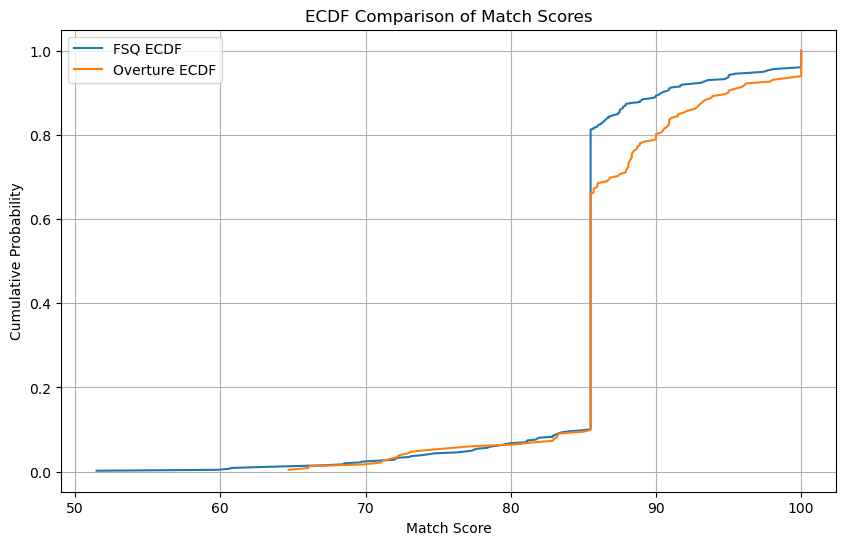

In [76]:
import numpy as np
import matplotlib.pyplot as plt

fsq_scores = matched_fsq['match_score']
overture_scores = matched_overture['match_score']

# Sort values
fsq_sorted = np.sort(fsq_scores)
overture_sorted = np.sort(overture_scores)

# Compute ECDF values
fsq_ecdf = np.arange(1, len(fsq_sorted)+1) / len(fsq_sorted)
overture_ecdf = np.arange(1, len(overture_sorted)+1) / len(overture_sorted)

# Plot ECDF
plt.figure(figsize=(10,6))
plt.plot(fsq_sorted, fsq_ecdf, label='FSQ ECDF')
plt.plot(overture_sorted, overture_ecdf, label='Overture ECDF')

plt.xlabel("Match Score")
plt.ylabel("Cumulative Probability")
plt.title("ECDF Comparison of Match Scores")
plt.legend()
plt.grid(True)
plt.show()


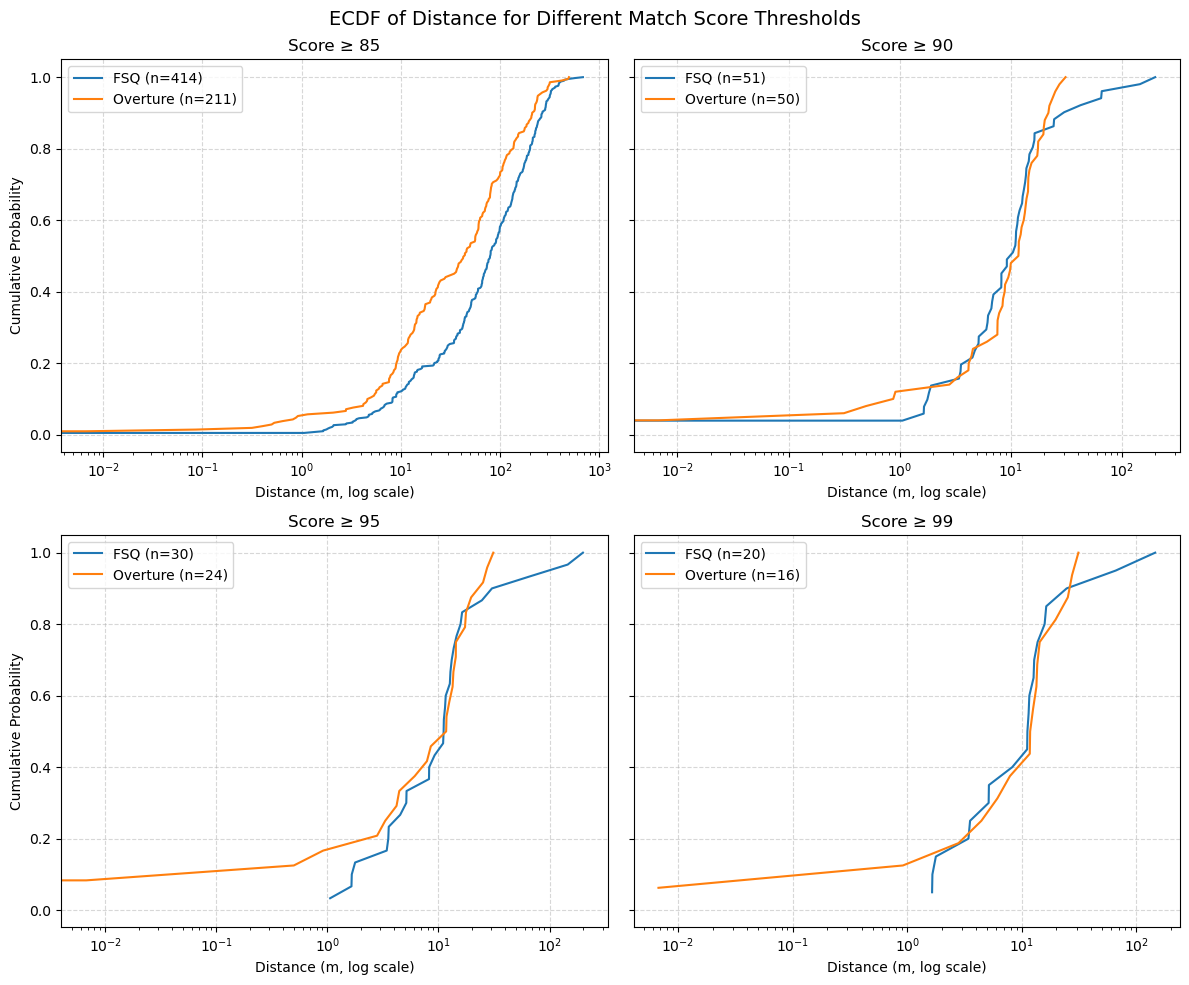

In [77]:
import numpy as np
import matplotlib.pyplot as plt

def ecdf(data):
    """Compute ECDF for a 1D array."""
    data = np.sort(data)
    n = len(data)
    y = np.arange(1, n+1) / n
    return data, y

thresholds = [85, 90, 95, 99]

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
axes = axes.ravel()

for ax, th in zip(axes, thresholds):
    fsq_sub = matched_fsq[
        (matched_fsq["match_score"] >= th) &
        (~matched_fsq["match_dist_m"].isna())
    ]
    ovt_sub = matched_overture[
        (matched_overture["match_score"] >= th) &
        (~matched_overture["match_dist_m"].isna())
    ]
    
    fsq_dist = fsq_sub["match_dist_m"].values
    ovt_dist = ovt_sub["match_dist_m"].values
    
    if len(fsq_dist) == 0 or len(ovt_dist) == 0:
        ax.text(0.5, 0.5, f"No data for threshold {th}", ha='center')
        ax.set_title(f"Score ≥ {th}")
        continue
    
    x_fsq, y_fsq = ecdf(fsq_dist)
    x_ovt, y_ovt = ecdf(ovt_dist)
    
    ax.plot(x_fsq, y_fsq, label=f"FSQ (n={len(fsq_dist)})")
    ax.plot(x_ovt, y_ovt, label=f"Overture (n={len(ovt_dist)})")
    
    ax.set_xscale("log")  
    ax.set_title(f"Score ≥ {th}")
    ax.set_xlabel("Distance (m, log scale)")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend()

axes[0].set_ylabel("Cumulative Probability")
axes[2].set_ylabel("Cumulative Probability")

fig.suptitle("ECDF of Distance for Different Match Score Thresholds", fontsize=14)
plt.tight_layout()
plt.show()


In [78]:
import pandas as pd
import numpy as np

def completeness_by_threshold(
    matched_df: pd.DataFrame,
    google_df: pd.DataFrame,
    thresholds=(85, 90, 95, 99),
    score_col="match_score",
    matched_id_col="matched_id",
    google_id_col="id",
    dist_col=None,
    max_dist=None,
    dataset_name="FSQ"
):
    """
    Compute completeness for multiple score thresholds.

    completeness(T) = (# unique Google IDs matched with score>=T [+ distance filter])
                      / (# unique Google IDs in google_df)
    """
    n_google = google_df[google_id_col].nunique()
    rows = []

    for th in thresholds:
        sub = matched_df.copy()

        # 1) score 过滤
        sub = sub[sub[score_col] >= th]

        # 2) 可选：距离过滤（例如只算 dist <= 30m 的匹配）
        if dist_col is not None and max_dist is not None:
            sub = sub[sub[dist_col] <= max_dist]

        # 3) 统计覆盖的 Google ID 数量
        n_covered = sub[matched_id_col].nunique()

        rows.append({
            "dataset": dataset_name,
            "threshold": th,
            "n_google_total": n_google,
            "n_google_covered": n_covered,
            "completeness": n_covered / n_google if n_google > 0 else np.nan
        })

    return pd.DataFrame(rows)


In [80]:
thresholds = [85, 90, 95, 99]

fsq_comp = completeness_by_threshold(
    matched_df=matched_fsq,
    google_df=google_placescat_100,
    thresholds=thresholds,
    score_col="match_score",
    matched_id_col="matched_id",
    google_id_col="id",
    dist_col="match_dist_m",   # 如果暂时不想加距离过滤，可以传 None
    max_dist=None,
    dataset_name="FSQ"
)

ovt_comp = completeness_by_threshold(
    matched_df=matched_overture,
    google_df=google_placescat_100,
    thresholds=thresholds,
    score_col="match_score",
    matched_id_col="matched_id",
    google_id_col="id",
    dist_col="match_dist_m",
    max_dist=None,
    dataset_name="Overture"
)

comp_all = pd.concat([fsq_comp, ovt_comp], ignore_index=True)
print(comp_all)

    dataset  threshold  n_google_total  n_google_covered  completeness
0       FSQ         85             212               119      0.561321
1       FSQ         90             212                50      0.235849
2       FSQ         95             212                30      0.141509
3       FSQ         99             212                20      0.094340
4  Overture         85             212               101      0.476415
5  Overture         90             212                48      0.226415
6  Overture         95             212                24      0.113208
7  Overture         99             212                16      0.075472


In [89]:
matched_overture.iloc[0]['categories']

{'primary': 'bank_credit_union', 'alternate': ['atms']}

In [85]:
matched_overture.iloc[1]['categories']

{'primary': 'religious_school', 'alternate': ['school', 'education']}

In [87]:
matched_overture.iloc[2]['categories']

{'primary': 'restaurant', 'alternate': ['fast_food_restaurant', 'diner']}

In [88]:
matched_overture.iloc[3]['categories']

{'primary': 'community_services_non_profits',
 'alternate': ['community_center', 'religious_organization']}

In [31]:
import geopandas as gpd
import folium

for gdf in [matched_overture, matched_fsq, google_placescat_100]:
    if gdf.crs is None or gdf.crs.to_epsg() != 4326:
        gdf.to_crs(epsg=4326, inplace=True)
m1 = matched_overture.explore(
    name="Overture",
    popup=["id", "name", "addr","match_key"],
    tooltip=False, 
    marker_type="circle_marker",
    marker_kwds={"radius": 6, "color": "red"},
    legend=True,
    legend_kwds={"label": "Overture Places", "color": "red"}
)

matched_fsq.explore(
    m=m1,
    name="Foursquare",
    popup=["id", "name", "addr","match_key"],
    tooltip=False, 
    marker_type="circle_marker",
    marker_kwds={"radius": 6, "color": "blue"},
    legend=True,
    legend_kwds={"label": "Foursquare Places", "color": "blue"}
)

google_placescat_100.explore(
    m=m1,
    name="Google Places (cat 100)",
    popup=["id", "name", "addr","match_key"],
    tooltip=False, 
    marker_type="circle_marker",
    marker_kwds={"radius": 6, "color": "green"},
    legend=True,
    legend_kwds={"label": "Google Places", "color": "green"}
)

folium.LayerControl(collapsed=False).add_to(m1)
m1

# Query from SafeGraph